LDA to Predict Star Types: Multiclass Classification
---
In the below cells we will walk through our implementation of Linear Discriminant Analysis on a multiclass classificaion problem. In particular, we will be predicting star types based on attributes of the star such as temperature, luminosity, size, etc.

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

## Loading data
We first load our data and observe its arrangement for preprocessing

In [ ]:
data = pd.read_csv("data/star_data.csv")
data

## Data preprocessing

As full disclosure, some editing was done on the source csv to begin with, but these edits were limited to arrangement of columns and grouping certain Star Color fields into one group, namely fixing letter cases and grouping unnecessarily pedantic distinctions of color into one group.


We immediately notice a few things:

1. The 'Star color' attribute is non-numeric
2. The 'Spectral Class' attribute is non-numeric

To preprocess the data in order to fix the first two observations, we can simply choose a suitable map of the star color and spectral classes to some integers.

We use the following scheme for the Star Color:

| Star Color         | Mapped Value |
|--------------------|--------------|
| Red                | -5           |
| Orange-Red         | -4           |
| Orange             | -3           |
| Pale yellow orange | -2           |
| Yellow-White       | -1           |
| Whitish            | 0            |
| White              | 1            |
| Blue-White         | 2            |
| Blue               | 3            |

We make this choices centered around `'White'` being `'1'`, the redder hues being more negative values, with the bluer hues being more positive.

We use the following scheme for the Spectral Class:
 
 | Spectral Class | Mapped Value |
|----------------|--------------|
| O              | 5            |
| B              | 4            |
| A              | 3            |
| F              | 2            |
| G              | 1            |
| K              | 0            |
| M              | -1           |

The rationale for these choices is again a simple heuristic that the Sun is classified as a a G type star, hence those stars in the G class will be similar to the Sun, with the redder, dimmer K and M star types being represented with the more negative numbers and the brighter, bluer star types O, B, A, and F being more positive numbers.

One thing to keep in mind when choosing the values to map the strings to is 

In [ ]:
spectra_map = {'O':5, 'B':4, 'A':3, 'F':2, 'G':1, 'K':0, 'M':-1}
data.replace(spectra_map,inplace=True)

# Reclassify star class 0 -> -1
#data.replace(0, 1, inplace=True)

color_map = { 'Red':-5, 'Orange-Red':-4, 'Orange':-3, 'Pale yellow orange':-2, 
             'Yellow-White':-1, 'Whitish':0, 'White':1,
             'Blue-White': 2, 'Blue':2}

data.replace(color_map, inplace=True)

data

## Implementing the algorithm

We rely on `scikitlearns`'s bult in model to implement.

To adjust the training data test size, simply adjust the `train_n` variable to an `int` for actual size of the data, or a `float` between `0` and `1.0` to define a percentage of the full dataset.

In [ ]:
# Function to split data into train and test sets
from sklearn.model_selection import train_test_split
# Tools to analyze model accuracy
from sklearn.metrics import accuracy_score

# Optional confusion matrix dependency
from sklearn.metrics import confusion_matrix


# Training data set size
train_n = 130

# Define train and test sets
A_train, A_test, b_train, b_test = train_test_split(
                              data.loc[:,'Temperature (K)':'Spectral Class']
                              , data.loc[:,'Star type'], 
                                   train_size=train_n, random_state=0)

# Initialize model
model = LDA(solver='lsqr')

# Fit training set
model.fit(A_train,b_train)

# Load predicted classes and analyze performace
predicted = model.predict(A_test)
#conf_mat = confusion_matrix(b_test,predicted)

#print(conf_mat)
print("Model accuracy:", accuracy_score(b_test,predicted))

## Accuracy analysis
The above implementation makes use of the `random_state` input in the `train_test_split` function which keeps the split consistent between multiple executions of the code. See the [scikitlearn documentation](https://https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for more information. 

As seen, this results in an accuracy of 99.09%. For a more robust picture of the LDA model accuracy, we take the median of the model's error over several random choices of training data.

In [ ]:
iterations = 100

def LDA_error():
  # Define train and test sets
  A_train, A_test, b_train, b_test = train_test_split(
                              data.loc[:,'Temperature (K)':'Spectral Class']
                              , data.loc[:,'Star type'], 
                                   train_size=train_n)
  # Initialize model
  model = LDA()
  # Fit training set
  model.fit(A_train,b_train)
  # Load accuracy
  return accuracy_score(b_test , model.predict(A_test))

errors = np.asarray([ LDA_error() for i in range(iterations) ] )

print(f"Median model accuracy over {len(errors)} iterations:", np.median(errors))

# LDA as a Supervised Dimension Reduction Technique

Having demonstrated the utility of LDA as a multiclass classifier model, we turn to another one of LDA's applications: dimension reduction.

Having already learned about Principal Component Analysis (PCA), we feel the only further motivation of the utility of LDA as a dimension reduction routine is to compare it PCA.

The primary difference between LDA and PCA as dimension reduction routines is that LDA is supervised, where the presence of the data's class labels is used to reduce the dimensionality of the data by using only the most discriminative attributes. It does this finding a projection subspace that maximizes the between-class scatter and minimizes the within-class scatter. Intuitively this can be though of as finding a subspace that maximizes the 'spread' between two different class labels while keeping the elements of one class a 'tight' as possible.

The use cases of LDA and PCA are also different. LDA is primarily used to reduce dimension in the case that class separability are desirable. On the other hand, PCA's ability to preserve the variance in data means it should be used when variance in data is desired.

The dimension of the reduced data is necessarily bounded above by `number_of_classes - 1`. In the case of our implementation, this means we will reduce the dimension from full square images to a dimension of 1(!). This is perhaps an extreme application, but instructive nevertheless. 

## LDA vs. PCA

Rather than explain the differences between LDA and PCA on a theoretical level, we practically demonstrate their differences by reducing the dimension of the classic wine quality dataset built into scikitlearn.

The wine quality dataset is a collection of 178 samples of distinct wines, noting 13(?) different attributes about each wine, that culminate in quality score. The quality scores are grouped into three classes, labelled `0`, `1`, and `2`.

In the below cell we run a very simple script of reducing these 13 dimensions to 2, and plotting the results to compare.

In [ ]:
from sklearn.datasets import load_wine
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

# Load and separate data
wine_full = load_wine()
wine_data = wine_full.data
wine_classes = wine_full.target

# Reduce dimension with LDA
lda_model = LDA(n_components=2)
lda_model.fit(wine_data, wine_classes)
lda_projected_data = lda_model.transform(wine_data)

# Reduce dimension with PCA
pca_model = PCA(n_components=2)
pca_model.fit(wine_data)
pca_projected_data = pca_model.transform(wine_data)

lda_classed = [lda_projected_data[wine_classes == i] for i in range(3)]
pca_classed = [pca_projected_data[wine_classes == i] for i in range(3)]

# Plot our results to compare
plt.figure(figsize=(19,10))
cols = ['red', 'blue', 'darkorange']
plt.subplot(1,2,1)
for cls, col in zip(lda_classed, cols):
    plt.scatter(cls[:,0],cls[:,1],color=col)

plt.title("LDA Projection")

plt.subplot(1,2,2)
for cls, col in zip(pca_classed, cols):
    plt.scatter(cls[:,0],cls[:,1],color=col)

plt.title("PCA Projection")
plt.show()


As one can see, the supervision of the LDA projection subspace gives it a clear advantage if the goal is to maintain separability between classes.

The plots may lead one to believe that PCA is a rather poor method to reduce dimensionality, but it should be remembered that PCA's primary goal is not to preserve class separability (it is unsupervised after all). Instead, PCA is superior in the preservation of **variance**.

In sum, if one is to think of dimension reduction as a means to reduce dimension while preserving 'fidelity', the usefulness of PCA and LDA will be determined by how one defines 'fidelity'. If data's distinction as being of a particular class is the desired fidelity, then LDA is appropriate, but if the data's uniqueness from the other data (i.e. variance) is a priority, then PCA is appropriate.

In [51]:
# We will only need these libraries in addition to those
### imported at the beginning
import os
import glob
from random import sample

# We'll need OpenCV to process the images
import cv2

Now we import the data and process it into a workable form for the scikitlearn implementation.

In [58]:
train_path_normal = 'data/chest_xray/chest_xray/train/NORMAL/'
train_path_pneum = 'data/chest_xray/chest_xray/train/PNEUMONIA/'

normal_ims = [ (im, 0) for im in glob.glob(train_path_normal +  '*.jpeg') ]
pneum_ims = [ (im, 1) for im in glob.glob(train_path_pneum + '*.jpeg') ]

normal_imvecs = []
pneum_imvecs = []

# Set desired number of images from train set
N = 750

normal_choices = sample(range(0,len(normal_ims)), N)
pneum_choices = sample(range(0,len(pneum_ims)), N)

# Set image resize dimensions
dim = 220

for i in normal_choices:
    pix_vec = cv2.imread( normal_ims[i][0])

    pix_vec.resize((dim,dim))
    pix_vec = np.append(np.reshape(pix_vec, dim*dim),0)

    normal_imvecs.append(pix_vec)


for i in pneum_choices:
    pix_vec = cv2.imread( pneum_ims[i][0])

    pix_vec.resize((dim,dim))
    pix_vec = np.append(np.reshape(pix_vec, dim*dim),1)

    pneum_imvecs.append(pix_vec)

immat = np.concatenate( (np.array(normal_imvecs), np.array(pneum_imvecs)) )

# Set numpy see for reproducibility
np.random.seed(20)
np.random.shuffle(immat)

data = immat[:,:(dim**2)]
classes = immat[:,(dim**2)]

Here we actually implement the LDA function

In [59]:
# n_components is bounded above by 1 as we are doing a binary classification
model = LDA(n_components=1)

reduced = model.fit_transform(data,classes)

Now we plot the results of the reduction.

If LDA is to succeed in its goal, we should see relatively good separation between the two classes, despite being projected down to such 
low dimensional space.

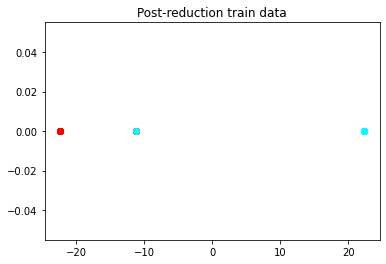

In [60]:
colors = [ 'red', 'blue' ]

zeros = reduced[classes == 0]
ones = reduced[classes == 1]

zeros = np.reshape(zeros, len(zeros))
ones = np.reshape(ones, len(ones))

plt.scatter(zeros, np.zeros(len(zeros)), color='red')
plt.scatter(ones, np.zeros(len(ones)), color='cyan')

plt.title("Post-reduction train data")
plt.show()

# After dimension reduction
At this point we have defined a projection subspace to reduce the dimension of the training data. To make this subspace useful, we can use the projection subspace to reduce the dimensionality of the test data, and then we may apply any choice of classification model on the reduced data.

The process of the below cell is identical to the above cells, except we apply `model.transform()` on the test data using the model from the previous cells.

In [ ]:
test_path_normal = 'data/chest_xray/chest_xray/test/NORMAL/'
test_path_pneum = 'data/chest_xray/chest_xray/test/PNEUMONIA/'

normal_ims_test = [ (im, 0) for im in glob.glob(test_path_normal +  '*.jpeg') ]
pneum_ims_test = [ (im, 1) for im in glob.glob(test_path_pneum + '*.jpeg') ]

normal_imvecs_test = []
pneum_imvecs_test = []

# Set desired number of images from train set
test_N = 30

normal_choices_test = sample(range(0,len(normal_ims_test)), test_N)
pneum_choices_test = sample(range(0,len(pneum_ims_test)), test_N)

for i in normal_choices_test:
    pix_vec = cv2.imread( normal_ims_test[i][0])

    pix_vec.resize((dim,dim))
    pix_vec = np.append(np.reshape(pix_vec, dim*dim),0)

    normal_imvecs_test.append(pix_vec)


for i in pneum_choices_test:
    pix_vec = cv2.imread( pneum_ims_test[i][0])

    pix_vec.resize((dim,dim))
    pix_vec = np.append(np.reshape(pix_vec, dim*dim), 1)

    pneum_imvecs_test.append(pix_vec)

immat_test = np.concatenate( (np.array(normal_imvecs_test), np.array(pneum_imvecs_test)) )
np.random.shuffle(immat_test)
test_attr = immat_test[:,:(dim**2)]
test_classes = immat_test[:,(dim**2)]

# Set numpy see for reproducibility
np.random.shuffle(immat_test)

model.fit(data,classes)

test_reduced = model.transform(test_attr)

colors = [ 'red', 'blue' ]

zeros = test_reduced[test_classes == 0]
ones = test_reduced[test_classes == 1]

test_zeros = np.reshape(zeros, len(zeros))
test_ones = np.reshape(ones, len(ones))

plt.scatter(zeros, np.zeros(len(zeros)), color='red')
plt.scatter(ones, np.zeros(len(ones)), color='cyan')

plt.title("Post-reduction test data to train-fitted model")
plt.show()